=== Mutual Information Ranking ===
           feature        mi
0               ts  0.693704
14         history  0.396934
16   orig_ip_bytes  0.374943
2        id.orig_p  0.373714
1        id.orig_h  0.348758
3        id.resp_h  0.301073
10      conn_state  0.266194
18   resp_ip_bytes  0.197520
4        id.resp_p  0.193337
15       orig_pkts  0.183381
9       resp_bytes  0.180281
8       orig_bytes  0.160030
17       resp_pkts  0.135023
7         duration  0.134867
12      local_resp  0.115948
6          service  0.081946
20        ip_proto  0.059041
5            proto  0.035562
11      local_orig  0.031533
13    missed_bytes  0.020598
19  tunnel_parents  0.000000


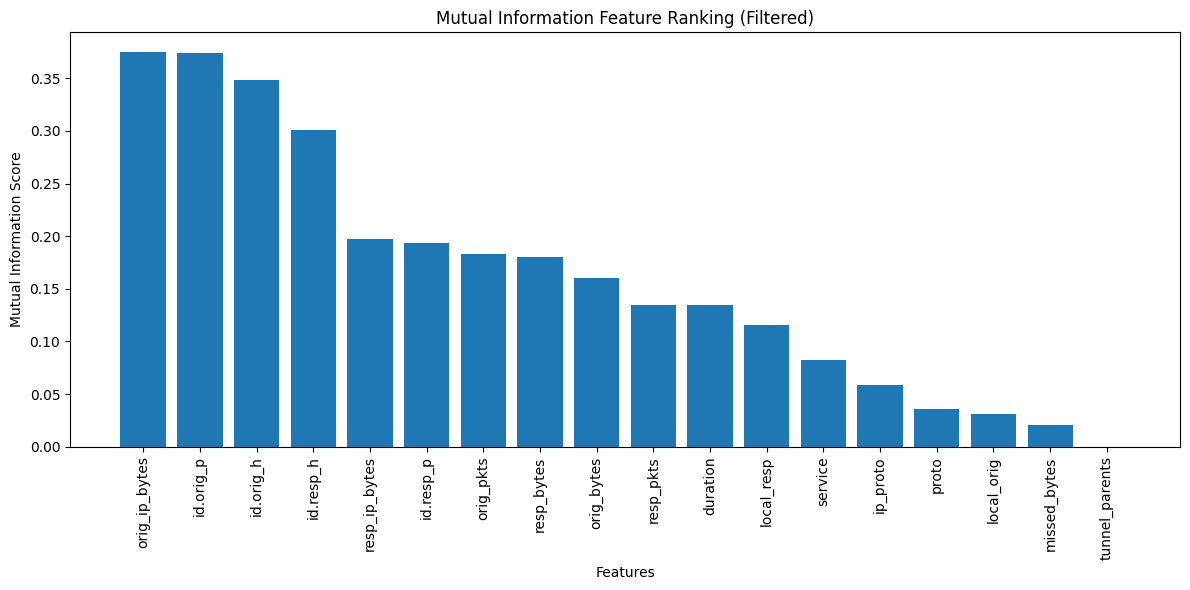


[INFO] Saved MI histogram as mi_feature_histogram.png
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best model: RandomForestClassifier(max_depth=15, n_estimators=200, random_state=42)

=== Sample RF Threat/Trust Scores with IPs ===
    orig_ip_str     resp_ip_str  rf_threat_score  rf_trust_score
0  192.168.0.13    192.168.0.16            0.000           1.000
1  192.168.0.13   248.250.9.234            0.000           1.000
2  192.168.0.24  223.39.118.176            0.065           0.935
3  192.168.0.24  211.188.147.64            0.015           0.985
4  192.168.0.24  223.39.118.176            0.000           1.000
5  192.168.0.24  223.39.123.191            0.020           0.980
6  192.168.0.24  223.39.123.191            0.015           0.985
7  192.168.0.24  223.39.118.176            0.000           1.000
8  192.168.0.24  223.39.118.176            0.000           1.000
9  192.168.0.24  223.39.118.176            0.015           0.985

=== Random Forest Feature Importance =

In [1]:
#========================================================
# FINAL CODE #3 - ML-DRIVEN POLICY (THREAT/TRUST SCORES)
#========================================================
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import json

# ============================================================
# 1. LOAD DATA
# ============================================================
data = pd.read_csv("/content/final_dataset.csv")
data = data.fillna(0)

# Keep an unencoded copy for human-readable values like IPs
original_data = data.copy()

# ============================================================
# 2. CLEAN + DROP NON-INFORMATIVE FEATURES
# ============================================================
drop_cols = ["uid"]
data = data.drop(columns=[c for c in drop_cols if c in data.columns])
original_data = original_data.drop(columns=[c for c in drop_cols if c in original_data.columns])

# Identify categorical columns
cat_cols = data.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != "label"]

# Encode categorical columns
encoders = {}
for col in cat_cols:
    enc = LabelEncoder()
    data[col] = enc.fit_transform(data[col].astype(str))
    encoders[col] = enc

# ============================================================
# 3. FEATURE SELECTION USING MUTUAL INFORMATION
# ============================================================
X = data.drop(columns=["label"])
y = data["label"]

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({"feature": X.columns, "mi": mi_scores})
mi_df = mi_df.sort_values(by="mi", ascending=False)

print("=== Mutual Information Ranking ===")
print(mi_df)

import matplotlib.pyplot as plt

# Exclude unwanted features
exclude_hist = {"ts", "conn_state", "history"}

mi_df_filtered = mi_df[~mi_df["feature"].isin(exclude_hist)]

plt.figure(figsize=(12, 6))
plt.bar(mi_df_filtered["feature"], mi_df_filtered["mi"])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Mutual Information Score")
plt.title("Mutual Information Feature Ranking (Filtered)")
plt.tight_layout()
plt.savefig("mi_feature_histogram.png")
plt.show()

print("\n[INFO] Saved MI histogram as mi_feature_histogram.png")

threshold = mi_df["mi"].median()
selected_features = mi_df[mi_df["mi"] > threshold]["feature"].tolist()
X_selected = X[selected_features]

# ============================================================
# 4. RANDOM FOREST WITH GRID SEARCH
# ============================================================
params = {"n_estimators": [200], "max_depth": [15], "random_state": [42]}
rf = RandomForestClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=rf,
    param_grid=params,
    cv=cv,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1
)

grid.fit(X_selected, y)
model = grid.best_estimator_
print("Best model:", model)

# ============================================================
# 4b. COMPUTE THREAT / TRUST SCORES (ML-DRIVEN)
# ============================================================
# rf_threat_score = P(attack), rf_trust_score = 1 - P(attack)
proba_attack = model.predict_proba(X_selected)[:, 1]
data["rf_threat_score"] = proba_attack
data["rf_trust_score"] = 1.0 - proba_attack

# Attach human-readable IPs for screenshots / reporting
data["orig_ip_str"] = original_data["id.orig_h"]
data["resp_ip_str"] = original_data["id.resp_h"]

print("\n=== Sample RF Threat/Trust Scores with IPs ===")
print(
    data[["orig_ip_str", "resp_ip_str", "rf_threat_score", "rf_trust_score"]]
    .head(10)
)

# ============================================================
# 5. ML-GUIDED FEATURE IMPORTANCE FOR POLICY
# ============================================================

rf_importance = pd.DataFrame({
    "feature": X_selected.columns,
    "importance": model.feature_importances_
}).sort_values(by="importance", ascending=False)

print("\n=== Random Forest Feature Importance ===")
print(rf_importance)

# ------------------------------
# REMOVE UNWANTED FEATURES FOR POLICY
# ------------------------------
excluded = {"ts", "history", "conn_state"}

filtered_importance = rf_importance[~rf_importance["feature"].isin(excluded)]

# Select top 5 remaining most important features
important_features = filtered_importance.head(5)["feature"].tolist()

# Always include id.resp_p for port-based policy (even if not in top 5)
if "id.resp_p" not in important_features and "id.resp_p" in X.columns:
    important_features.append("id.resp_p")

# Prefer to include resp_bytes as well (for volume-based rules)
if "resp_bytes" in X.columns and "resp_bytes" not in important_features:
    important_features.append("resp_bytes")

print("\nSelected Important Features (After filtering, + forcing id.resp_p & resp_bytes):")
print(important_features)

# ============================================================
# 5b. HELPER FUNCTIONS
# ============================================================

def extract_device_policy_flows(encoded_ip, trust_threshold=0.7):
    """
    Return flows for device that are 'trusted enough' according to the ML model.
    We treat flows with rf_trust_score >= trust_threshold as benign-like behavior.
    This is the core ML-driven step.
    """
    df_dev = data[
        (data["id.orig_h"] == encoded_ip) |
        (data["id.resp_h"] == encoded_ip)
    ].copy()

    df_trusted = df_dev[df_dev["rf_trust_score"] >= trust_threshold]

    print(f"Total flows for device (encoded={encoded_ip}): {len(df_dev)}")
    print(f"Trusted flows (rf_trust_score >= {trust_threshold}): {len(df_trusted)}")

    return df_trusted


def compute_feature_range(df, feature):
    """Min/max range used for anomaly boundaries."""
    return (df[feature].min(), df[feature].max())


def compute_allowed_values(df, feature):
    """Allowed ports/values for categorical fields."""
    return sorted(df[feature].unique().tolist())

# ============================================================
# 6. MAIN ML-DRIVEN POLICY GENERATOR
# ============================================================

def generate_ml_driven_policy(device_ip, trust_threshold=0.7):
    """
    ML-driven policy:
    - Use only flows that the RF model considers sufficiently 'trusted'
    - Restrict to protocols actually seen in those trusted flows
    - For each IMPORTANT feature, build:
      * allowed values (for ports)
      * min/max ranges (for numeric features)
    """
    encoded_ip = encoders["id.orig_h"].transform([device_ip])[0]
    df_device = extract_device_policy_flows(encoded_ip, trust_threshold=trust_threshold)

    print(f"\nTrusted flows used for policy for {device_ip}: {len(df_device)}")

    if df_device.empty:
        return {}

    protocols = df_device["proto"].unique().tolist()
    policy = {}

    for encoded_proto in protocols:
        proto_str = encoders["proto"].inverse_transform([encoded_proto])[0]
        subset = df_device[df_device["proto"] == encoded_proto].copy()

        if subset.empty:
            continue

        rules = {}

        for feat in important_features:
            if feat not in subset.columns:
                continue

            # Ports: build allow-list
            if feat in ["id.orig_p", "id.resp_p"]:
                rules[f"allowed_{feat}"] = compute_allowed_values(subset, feat)
            else:
                low, high = compute_feature_range(subset, feat)
                rules[f"{feat}_range"] = (low, high)

        if rules:
            policy[proto_str] = rules

    return policy


def print_policy(policy):
    for proto, rules in policy.items():
        print(f"\nProtocol: {proto}")
        for k, v in rules.items():
            print(f"  - {k}: {v}")

# ============================================================
# 7. SNORT RULE GENERATION FROM ML-DRIVEN POLICY
# ============================================================

def generate_snort_rules_for_device(device_ip, policy, base_sid=5000001):
    """
    Convert an ML-driven policy for a single device into Snort rules.

    Rules generated:
      1) Port allow-list rule (per protocol): alert on dest ports NOT in allow-list.
      2) If resp_bytes_range exists: high-volume response rule using dsize threshold.
    """
    rules = []
    sid = base_sid

    for proto, rules_dict in policy.items():
        proto_l = proto.lower()
        if proto_l not in ("tcp", "udp"):
            continue

        # 1) PORT ALLOW-LIST RULE
        allowed_key = "allowed_id.resp_p"
        if allowed_key in rules_dict:
            allowed_ports = rules_dict[allowed_key]
            if allowed_ports:
                ports_str = ",".join(str(int(p)) for p in allowed_ports)

                port_rule = (
                    f"alert {proto_l} {device_ip} any -> any ![{ports_str}] "
                    f'(msg:"ZTASG: unexpected {proto_l.upper()} dest port for {device_ip}"; '
                    f"classtype:policy-violation; sid:{sid}; rev:1;)"
                )
                rules.append(port_rule)
                sid += 1

        # 2) HIGH-VOLUME RESPONSE RULE (using resp_bytes_range -> dsize)
        if "resp_bytes_range" in rules_dict and proto_l == "tcp":
            low_bytes, high_bytes = rules_dict["resp_bytes_range"]
            # Choose a threshold near upper bound (e.g., 90% of max)
            volume_threshold = int(0.9 * high_bytes) if high_bytes > 0 else 0

            if volume_threshold > 0:
                dsize_rule = (
                    f"alert tcp {device_ip} any -> any any "
                    f'(msg:"ZTASG: anomalous response volume for {device_ip}"; '
                    f"flow:to_client,established; "
                    f"dsize:>{volume_threshold}; "
                    f"classtype:policy-violation; sid:{sid}; rev:1;)"
                )
                rules.append(dsize_rule)
                sid += 1

    return rules, sid

# ============================================================
# 8. GENERATE POLICIES AND SNORT RULES FOR BOTH DEVICES
# ============================================================

# TRUST THRESHOLD: change this to see how policies adapt (0.5, 0.7, 0.9, etc.)
TRUST_THRESHOLD = 0.7

policy_13 = generate_ml_driven_policy("192.168.0.13", trust_threshold=TRUST_THRESHOLD)
print("\n=== ML-DRIVEN POLICY FOR 192.168.0.13 ===")
print_policy(policy_13)

policy_24 = generate_ml_driven_policy("192.168.0.24", trust_threshold=TRUST_THRESHOLD)
print("\n=== ML-DRIVEN POLICY FOR 192.168.0.24 ===")
print_policy(policy_24)

# Generate Snort rules
all_rules = []
sid = 5000001

rules_13, sid = generate_snort_rules_for_device("192.168.0.13", policy_13, base_sid=sid)
all_rules.extend(rules_13)

rules_24, sid = generate_snort_rules_for_device("192.168.0.24", policy_24, base_sid=sid)
all_rules.extend(rules_24)

print("\n=== GENERATED SNORT RULES (TRUST_THRESHOLD =", TRUST_THRESHOLD, ") ===")
for r in all_rules:
    print(r)

with open("ztasg.rules", "w") as f:
    f.write("\n".join(all_rules) + "\n")

print("\n[INFO] Wrote Snort rules to ztasg.rules")